# Distribution of NO<sub>2</sub> by CAMS and TROPOMI

### Main goal

Show side by side the total columns of NO<sub>2</sub> from CAMS and TROPOMI datasets.

### Selected period and study area
* Period: 21/07/2021 between 00:00:00 and 18:00:00
* Location: Czech Republic

### TODO
* Add apriori data to calculate component column 

## Imports and supporting functions

In [1]:
"""
Observations:
- The library cartopy needs the following:
sudo apt-get install libproj-dev proj-data proj-bin 
sudo apt-get install libgeos-dev 
sudo pip install cython

- eccodes must be installed to be able to read grib files and it only works in Ubuntu
Reference: https://gist.github.com/MHBalsmeier/a01ad4e07ecf467c90fad2ac7719844a
"""

'\nObservations:\n- The library cartopy needs the following:\nsudo apt-get install libproj-dev proj-data proj-bin \nsudo apt-get install libgeos-dev \nsudo pip install cython\n\n- eccodes must be installed to be able to read grib files and it only works in Ubuntu\nReference: https://gist.github.com/MHBalsmeier/a01ad4e07ecf467c90fad2ac7719844a\n'

In [2]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import xarray as xr

In [3]:
%run functions.ipynb

In [4]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

## 1. Define study area

In [5]:
# Define limit latitudes and longitudes
lat_min = 48.5
lat_max = 51.1
lon_min = 12
lon_max = 18.9

# Create bbox
bbox = ((lon_min, lat_min), (lon_max, lat_max))

## 2. Define datasets

In [6]:
# Define component
component = 'nitrogen_dioxide'
component_nom = 'NO2'
component_mol_weight = 46.005 #g/mol

# CAMS: Define period
start_date = '2021-07-21'
end_date = '2021-07-21'

# TROPOMI: Define file and product name
file_name = '42ceb065-e6e8-4783-9e6b-4a01d266f54d'
product_name = 'S5P_NRTI_L2__NO2____20210721T113737_20210721T114237_19537_02_020200_20210721T124127.nc'

## 3. CAMS data

### Collect and read data as xarray

In [7]:
CAMS_download(start_date, end_date, component, component_nom)
CAMS_ds = CAMS_read(start_date, end_date, component, component_nom)
CAMS_ds

2021-07-24 07:19:31,653 INFO Welcome to the CDS
2021-07-24 07:19:31,654 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts
2021-07-24 07:19:31,667 INFO Request is queued
2021-07-24 07:19:32,676 INFO Request is running
2021-07-24 07:20:21,030 INFO Request is completed
2021-07-24 07:20:21,031 INFO Downloading https://download-0002.copernicus-atmosphere.eu/cache-compute-0002/cache/data0/adaptor.mars_constrained.internal-1627111202.1383545-25206-19-74b651b4-ac23-4547-8816-14ef90ac4ecd.grib to data/ads/NO2/NO2-levels-2021-07-21-2021-07-21.grib (637.1M)
2021-07-24 07:20:31,924 INFO Download rate 58.5M/s


<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 451, longitude: 900, step: 4)
Coordinates:
    time        datetime64[ns] ...
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 -90.0 -89.6 -89.2 -88.8 ... 89.2 89.6 90.0
  * longitude   (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
    valid_time  (step) datetime64[ns] ...
Data variables:
    component   (step, hybrid, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-07-24T07:20 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [8]:
# Read csv table with 137 levels
CAMS_levels = pd.read_csv('data/ads/137-levels.csv')

# Drop first row and set n as index hybrid
CAMS_levels = CAMS_levels.drop(0).reset_index(drop = True)
CAMS_levels = CAMS_levels.set_index('n')
CAMS_levels.index.names = ['hybrid']

# Change important columns to numeric
CAMS_levels['pf [hPa]'] = pd.to_numeric(CAMS_levels['pf [hPa]'])
CAMS_levels['Geopotential Altitude [m]'] = pd.to_numeric(CAMS_levels['Geopotential Altitude [m]'])
CAMS_levels['Density [kg/m^3]'] = pd.to_numeric(CAMS_levels['Density [kg/m^3]'])

# Calculate difference from geopotential altitude
CAMS_levels['Depth [m]'] = CAMS_levels['Geopotential Altitude [m]'].diff(-1)

# Add layer depth to last row manually
CAMS_levels['Depth [m]'].iloc[-1] = CAMS_levels['Geopotential Altitude [m]'].iloc[-1]

CAMS_levels

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],Depth [m]
hybrid,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,2320.96
...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,22.96


### Reduce data to study area

In [9]:
# Get nearest longitude and latitude to bbox
lon_min_index = nearest_neighbour(CAMS_ds.longitude.data, bbox[0][0])
lon_max_index = nearest_neighbour(CAMS_ds.longitude.data, bbox[1][0])
lat_min_index = nearest_neighbour(CAMS_ds.latitude.data, bbox[0][1])
lat_max_index = nearest_neighbour(CAMS_ds.latitude.data, bbox[1][1])

# Define slices
slice_lat = slice(lat_min_index, lat_max_index + 1)
slice_lon = slice(lon_min_index, lon_max_index + 1)

# Set limits
CAMS_ds = CAMS_ds.isel(longitude = slice_lon, latitude = slice_lat)

CAMS_ds

<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 8, longitude: 18, step: 4)
Coordinates:
    time        datetime64[ns] 2021-07-21
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 48.4 48.8 49.2 49.6 50.0 50.4 50.8 51.2
  * longitude   (longitude) float64 12.0 12.4 12.8 13.2 ... 17.6 18.0 18.4 18.8
    valid_time  (step) datetime64[ns] 2021-07-21 ... 2021-07-21T18:00:00
Data variables:
    component   (step, hybrid, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-07-24T07:20 GRIB to CDM+CF via cfgrib-0.9.9...

## 4. TROPOMI data

### Collect and read data as xarray

In [10]:
TROPOMI_download(file_name, component_nom)
TROPOMI_ds = TROPOMI_read(product_name, component_nom)
TROPOMI_ds

2021-07-24 07:20:37,204 INFO Downloading 42ceb065-e6e8-4783-9e6b-4a01d266f54d to data/tropomi/NO2/S5P_NRTI_L2__NO2____20210721T113737_20210721T114237_19537_02_020200_20210721T124127.nc


Downloading:   0%|          | 0.00/62.3M [00:00<?, ?B/s]

MD5 checksumming:   0%|          | 0.00/62.3M [00:00<?, ?B/s]

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 372, time: 1, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    TROPOMI_column                                        (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...

### Calculate pressure

In [11]:
# Read support data to calculate pressure
support_ds = xr.open_dataset('data/tropomi/' + component_nom + '/' + product_name, group = 'PRODUCT/SUPPORT_DATA/INPUT_DATA')

# Calculate pressure as p = ap + b * ps
p = TROPOMI_ds.tm5_constant_a + TROPOMI_ds.tm5_constant_b * support_ds.surface_pressure / 100
TROPOMI_ds = TROPOMI_ds.assign(pressure = p)

TROPOMI_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 372, time: 1, vertices: 2)
Coordinates:
  * ground_pixel                                          (ground_pixel) float64 ...
  * scanline                                              (scanline) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables: (12/13)
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    TROPOMI_column                                        (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    ...                                                    ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...
    pressure                                              (layer, vertices, time, scanline, ground_pixel) float32 ...

### Reduce data to study area

In [14]:
# Create dataframe with scanlines and ground pixels
TROPOMI_df = []
TROPOMI_df = pd.DataFrame(list(product(TROPOMI_ds.ground_pixel.values, TROPOMI_ds.scanline.values)), 
                          columns = ['ground_pixel', 'scanline'])

# Find corresponding latitudes and longitudes                          
for index, row in TROPOMI_df.iterrows():
    TROPOMI_df.loc[index,'latitude'] = TROPOMI_ds.latitude.sel(
                                        scanline = TROPOMI_df['scanline'].loc[index], 
                                        ground_pixel = TROPOMI_df['ground_pixel'].loc[index]).values
                                        
    TROPOMI_df.loc[index,'longitude'] = TROPOMI_ds.longitude.sel(
                                        scanline = TROPOMI_df['scanline'].loc[index], 
                                        ground_pixel = TROPOMI_df['ground_pixel'].loc[index]).values

# Save as csv
TROPOMI_df.to_csv('data/tropomi/TROPOMI_df_' + product_name + '.csv', index = False)

In [15]:
# Read csv
TROPOMI_df = pd.read_csv('data/tropomi/TROPOMI_df_' + product_name + '.csv')

# Set limits
TROPOMI_df = TROPOMI_df[(TROPOMI_df['latitude'] >= lat_min) & (TROPOMI_df['latitude'] <= lat_max)]
TROPOMI_df = TROPOMI_df[(TROPOMI_df['longitude'] >= lon_min) & (TROPOMI_df['longitude'] <= lon_max)]

TROPOMI_df

,ground_pixel,scanline,latitude,longitude
47436,127.0,192.0,48.524662,12.041742
47437,127.0,193.0,48.572155,12.015845
47808,128.0,192.0,48.541588,12.098797
47809,128.0,193.0,48.589092,12.072948
47810,128.0,194.0,48.636585,12.047018
...,...,...,...,...
100279,269.0,211.0,51.004551,18.815954
100280,269.0,212.0,51.053074,18.796009
100650,270.0,210.0,50.963562,18.888651
100651,270.0,211.0,51.012062,18.868759


In [16]:
# Get nearest longitude and latitude to bbox
gp_min_index = nearest_neighbour(TROPOMI_ds.ground_pixel.data, np.min(TROPOMI_df['ground_pixel']))
gp_max_index = nearest_neighbour(TROPOMI_ds.ground_pixel.data, np.max(TROPOMI_df['ground_pixel']))
sl_min_index = nearest_neighbour(TROPOMI_ds.scanline.data, np.min(TROPOMI_df['scanline']))
sl_max_index = nearest_neighbour(TROPOMI_ds.scanline.data, np.max(TROPOMI_df['scanline']))

# Define slices
slice_gp = slice(gp_min_index, gp_max_index)
slice_sl = slice(sl_min_index, sl_max_index)

# Set limits
TROPOMI_ds = TROPOMI_ds.isel(ground_pixel = slice_gp, scanline = slice_sl)

TROPOMI_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 143, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 75, time: 1, vertices: 2)
Coordinates:
  * ground_pixel                                          (ground_pixel) float64 ...
  * scanline                                              (scanline) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables: (12/13)
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    TROPOMI_column                                        (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    ...                                                    ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...
    pressure                                              (layer, vertices, time, scanline, ground_pixel) float32 ...

### Calculate column averaging kernels

In [17]:
kernel_column_da = xr.where(TROPOMI_ds.layer > TROPOMI_ds.tm5_tropopause_layer_index, 0, 
                            TROPOMI_ds.averaging_kernel * (TROPOMI_ds.air_mass_factor_total / 
                            TROPOMI_ds.air_mass_factor_troposphere))

TROPOMI_ds = TROPOMI_ds.assign(kernel_column = kernel_column_da)

TROPOMI_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 143, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 75, time: 1, vertices: 2)
Coordinates:
  * ground_pixel                                          (ground_pixel) float64 ...
  * scanline                                              (scanline) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables: (12/14)
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    TROPOMI_column                                        (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    ...                                                    ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...
    pressure                                              (layer, vertices, time, scanline, ground_pixel) float32 ...
    kernel_column                                         (layer, time, scanline, ground_pixel) float32 ...

## 5. Apply averaging kernels

### Linear interpolation of CAMS data to 100x100

In [18]:
#CAMS_ds_new =  CAMS_interpolation(CAMS_ds, TROPOMI_ds, lon_min, lon_max, lat_min, lat_max, component_nom)

### Convert units (kg/kg to molecules/cm<sup>2</sup>)

In [19]:
# Create xarray object from levels df
CAMS_levels_ds = CAMS_levels.to_xarray()

# From kg/kg to kg/m3
CAMS_ds = CAMS_ds * CAMS_levels_ds['Density [kg/m^3]']

# From kg/m3 to kg/m2
CAMS_ds = CAMS_ds * CAMS_levels_ds['Depth [m]']

# From kg/m2 to molecules/cm2
NA = 6.022*10**23
CAMS_ds = (CAMS_ds * NA * 1000) / (10000 * component_mol_weight)

CAMS_ds

<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 8, longitude: 18, step: 4)
Coordinates:
    time        datetime64[ns] 2021-07-21
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 48.4 48.8 49.2 49.6 50.0 50.4 50.8 51.2
  * longitude   (longitude) float64 12.0 12.4 12.8 13.2 ... 17.6 18.0 18.4 18.8
    valid_time  (step) datetime64[ns] 2021-07-21 ... 2021-07-21T18:00:00
Data variables:
    component   (step, hybrid, latitude, longitude) float64 2.205e+11 ... 7.2...

### Transform TROPOMI ds into df

In [20]:
TROPOMI_df = TROPOMI_ds.to_dataframe()

In [21]:
TROPOMI_df = TROPOMI_df.drop(columns=['nitrogendioxide_tropospheric_column_precision', 
                                      'nitrogendioxide_tropospheric_column_precision_kernel',
                                      'averaging_kernel',
                                      'air_mass_factor_troposphere',
                                      'air_mass_factor_total',
                                      'tm5_tropopause_layer_index',
                                      'tm5_constant_a',
                                      'tm5_constant_b',
                                      'time_utc'])

TROPOMI_df = TROPOMI_df.droplevel(['corner', 'intensity_offset_polynomial_exponents', 'polynomial_exponents']).drop_duplicates()
TROPOMI_df = TROPOMI_df.groupby(by = ['layer', 'ground_pixel', 'scanline', 'time', 'delta_time']).mean()
TROPOMI_df = TROPOMI_df.reset_index(level = 'delta_time')
TROPOMI_df

delta_time   latitude  \
layer ground_pixel scanline time                                            
0.0   127.0        163.0    2021-07-21 2021-07-21 11:39:49.010  47.145008   
                   164.0    2021-07-21 2021-07-21 11:39:49.850  47.192677   
                   165.0    2021-07-21 2021-07-21 11:39:50.690  47.240311   
                   166.0    2021-07-21 2021-07-21 11:39:51.530  47.287945   
                   167.0    2021-07-21 2021-07-21 11:39:52.370  47.335583   
...                                                        ...        ...   
33.0  269.0        233.0    2021-07-21 2021-07-21 11:40:47.809  52.070900   
                   234.0    2021-07-21 2021-07-21 11:40:48.649  52.119339   
                   235.0    2021-07-21 2021-07-21 11:40:49.489  52.167770   
                   236.0    2021-07-21 2021-07-21 11:40:50.329  52.216206   
                   237.0    2021-07-21 2021-07-21 11:40:51.169  52.264641   

                                        longitude  qa_value  TROPOMI_column  \
layer ground_pixel scanline time                                              
0.0   127.0        163.0    2021-07-21  12.773775      1.00        0.000002   
                   164.0    2021-07-21  12.749171      1.00        0.000019   
                   165.0    2021-07-21  12.724477      1.00        0.000027   
                   166.0    2021-07-21  12.699731      1.00        0.000008   
                   167.0    2021-07-21  12.674969      1.00        0.000018   
...                                           ...       ...             ...   
33.0  269.0        233.0    2021-07-21  18.368704      0.74        0.000008   
                   234.0    2021-07-21  18.347986      0.74        0.000011   
                   235.0    2021-07-21  18.327244      0.74        0.000007   
                   236.0    2021-07-21  18.306442      0.74        0.000018   
                   237.0    2021-07-21  18.285561      0.74        0.000016   

                                          pressure  kernel_column  
layer ground_pixel scanline time                                   
0.0   127.0        163.0    2021-07-21  774.826233       0.113335  
                   164.0    2021-07-21  788.096436       0.239486  
                   165.0    2021-07-21  846.909546       0.456600  
                   166.0    2021-07-21  882.467651       0.276312  
                   167.0    2021-07-21  845.959595       0.436940  
...                                            ...            ...  
33.0  269.0        233.0    2021-07-21    0.000000       0.000000  
                   234.0    2021-07-21    0.000000       0.000000  
                   235.0    2021-07-21    0.000000       0.000000  
                   236.0    2021-07-21    0.000000       0.000000  
                   237.0    2021-07-21    0.000000       0.000000  

[364650 rows x 7 columns]

### Convert units (mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [22]:
TROPOMI_df['TROPOMI_column'] = TROPOMI_df['TROPOMI_column'] * 6.02214*10**19

### Pass NaNs to data with qa_value under 0.5

In [23]:
TROPOMI_df.loc[TROPOMI_df['qa_value'] < 0.5, ['TROPOMI_column', 'kernel_column']] = float('NaN')

### Combine data (nearest neighbours)

In [24]:
match_df = TROPOMI_df

CAMS_latitudes = CAMS_ds.latitude.data
CAMS_longitudes = CAMS_ds.longitude.data
CAMS_pressures = CAMS_levels['pf [hPa]'].to_numpy()
CAMS_times = CAMS_ds.valid_time.data

match_df['lat_index'] = match_df.apply(lambda row: nearest_neighbour(CAMS_latitudes, row['latitude']), axis = 1)
match_df['lon_index'] = match_df.apply(lambda row: nearest_neighbour(CAMS_longitudes, row['longitude']), axis = 1)
match_df['lay_index'] = match_df.apply(lambda row: nearest_neighbour(CAMS_pressures, row['pressure']), axis = 1)
match_df['step_index'] = match_df.apply(lambda row: nearest_neighbour(CAMS_times, row['delta_time']), axis = 1)
match_df['CAMS_time'] = match_df.apply(lambda row: CAMS_ds.valid_time[row['step_index']].values, axis = 1)

match_df['CAMS_component'] = match_df.apply(lambda row: CAMS_ds.component.isel(hybrid = int(row['lay_index']) - 1, 
                        latitude = int(row['lat_index']), longitude = int(row['lon_index']), step = int(row['step_index'])).values, axis = 1)

match_df

delta_time   latitude  \
layer ground_pixel scanline time                                            
0.0   127.0        163.0    2021-07-21 2021-07-21 11:39:49.010  47.145008   
                   164.0    2021-07-21 2021-07-21 11:39:49.850  47.192677   
                   165.0    2021-07-21 2021-07-21 11:39:50.690  47.240311   
                   166.0    2021-07-21 2021-07-21 11:39:51.530  47.287945   
                   167.0    2021-07-21 2021-07-21 11:39:52.370  47.335583   
...                                                        ...        ...   
33.0  269.0        233.0    2021-07-21 2021-07-21 11:40:47.809  52.070900   
                   234.0    2021-07-21 2021-07-21 11:40:48.649  52.119339   
                   235.0    2021-07-21 2021-07-21 11:40:49.489  52.167770   
                   236.0    2021-07-21 2021-07-21 11:40:50.329  52.216206   
                   237.0    2021-07-21 2021-07-21 11:40:51.169  52.264641   

                                        longitude  qa_value  TROPOMI_column  \
layer ground_pixel scanline time                                              
0.0   127.0        163.0    2021-07-21  12.773775      1.00    9.389191e+13   
                   164.0    2021-07-21  12.749171      1.00    1.147599e+15   
                   165.0    2021-07-21  12.724477      1.00    1.635275e+15   
                   166.0    2021-07-21  12.699731      1.00    4.603524e+14   
                   167.0    2021-07-21  12.674969      1.00    1.082807e+15   
...                                           ...       ...             ...   
33.0  269.0        233.0    2021-07-21  18.368704      0.74    4.971788e+14   
                   234.0    2021-07-21  18.347986      0.74    6.352350e+14   
                   235.0    2021-07-21  18.327244      0.74    4.344397e+14   
                   236.0    2021-07-21  18.306442      0.74    1.095391e+15   
                   237.0    2021-07-21  18.285561      0.74    9.665273e+14   

                                          pressure  kernel_column  lat_index  \
layer ground_pixel scanline time                                               
0.0   127.0        163.0    2021-07-21  774.826233       0.113335          0   
                   164.0    2021-07-21  788.096436       0.239486          0   
                   165.0    2021-07-21  846.909546       0.456600          0   
                   166.0    2021-07-21  882.467651       0.276312          0   
                   167.0    2021-07-21  845.959595       0.436940          0   
...                                            ...            ...        ...   
33.0  269.0        233.0    2021-07-21    0.000000       0.000000          7   
                   234.0    2021-07-21    0.000000       0.000000          7   
                   235.0    2021-07-21    0.000000       0.000000          7   
                   236.0    2021-07-21    0.000000       0.000000          7   
                   237.0    2021-07-21    0.000000       0.000000          7   

                                        lon_index  lay_index  step_index  \
layer ground_pixel scanline time                                           
0.0   127.0        163.0    2021-07-21          2        108           2   
                   164.0    2021-07-21          2        109           2   
                   165.0    2021-07-21          2        113           2   
                   166.0    2021-07-21          2        115           2   
                   167.0    2021-07-21          2        113           2   
...                                           ...        ...         ...   
33.0  269.0        233.0    2021-07-21         16          0           2   
                   234.0    2021-07-21         16          0           2   
                   235.0    2021-07-21         16          0           2   
                   236.0    2021-07-21         16          0           2   
                   237.0    2021-07-21         16          0         

### Calculate CAMS columns

In [25]:
# Calculate values to generate CAMS column to sum in the next step
match_df['CAMS_column'] = match_df.apply(lambda row: row['CAMS_component'] * 
                                                     row['kernel_column'], 
                                                     axis = 1)

match_df

delta_time   latitude  \
layer ground_pixel scanline time                                            
0.0   127.0        163.0    2021-07-21 2021-07-21 11:39:49.010  47.145008   
                   164.0    2021-07-21 2021-07-21 11:39:49.850  47.192677   
                   165.0    2021-07-21 2021-07-21 11:39:50.690  47.240311   
                   166.0    2021-07-21 2021-07-21 11:39:51.530  47.287945   
                   167.0    2021-07-21 2021-07-21 11:39:52.370  47.335583   
...                                                        ...        ...   
33.0  269.0        233.0    2021-07-21 2021-07-21 11:40:47.809  52.070900   
                   234.0    2021-07-21 2021-07-21 11:40:48.649  52.119339   
                   235.0    2021-07-21 2021-07-21 11:40:49.489  52.167770   
                   236.0    2021-07-21 2021-07-21 11:40:50.329  52.216206   
                   237.0    2021-07-21 2021-07-21 11:40:51.169  52.264641   

                                        longitude  qa_value  TROPOMI_column  \
layer ground_pixel scanline time                                              
0.0   127.0        163.0    2021-07-21  12.773775      1.00    9.389191e+13   
                   164.0    2021-07-21  12.749171      1.00    1.147599e+15   
                   165.0    2021-07-21  12.724477      1.00    1.635275e+15   
                   166.0    2021-07-21  12.699731      1.00    4.603524e+14   
                   167.0    2021-07-21  12.674969      1.00    1.082807e+15   
...                                           ...       ...             ...   
33.0  269.0        233.0    2021-07-21  18.368704      0.74    4.971788e+14   
                   234.0    2021-07-21  18.347986      0.74    6.352350e+14   
                   235.0    2021-07-21  18.327244      0.74    4.344397e+14   
                   236.0    2021-07-21  18.306442      0.74    1.095391e+15   
                   237.0    2021-07-21  18.285561      0.74    9.665273e+14   

                                          pressure  kernel_column  lat_index  \
layer ground_pixel scanline time                                               
0.0   127.0        163.0    2021-07-21  774.826233       0.113335          0   
                   164.0    2021-07-21  788.096436       0.239486          0   
                   165.0    2021-07-21  846.909546       0.456600          0   
                   166.0    2021-07-21  882.467651       0.276312          0   
                   167.0    2021-07-21  845.959595       0.436940          0   
...                                            ...            ...        ...   
33.0  269.0        233.0    2021-07-21    0.000000       0.000000          7   
                   234.0    2021-07-21    0.000000       0.000000          7   
                   235.0    2021-07-21    0.000000       0.000000          7   
                   236.0    2021-07-21    0.000000       0.000000          7   
                   237.0    2021-07-21    0.000000       0.000000          7   

                                        lon_index  lay_index  step_index  \
layer ground_pixel scanline time                                           
0.0   127.0        163.0    2021-07-21          2        108           2   
                   164.0    2021-07-21          2        109           2   
                   165.0    2021-07-21          2        113           2   
                   166.0    2021-07-21          2        115           2   
                   167.0    2021-07-21          2        113           2   
...                                           ...        ...         ...   
33.0  269.0        233.0    2021-07-21         16          0           2   
                   234.0    2021-07-21         16          0           2   
                   235.0    2021-07-21         16          0           2   
                   236.0    2021-07-21         16          0           2   
                   237.0    2021-07-21         16          0         

In [26]:
match_ds = match_df.to_xarray()
match_ds

<xarray.Dataset>
Dimensions:         (ground_pixel: 143, layer: 34, scanline: 75, time: 1)
Coordinates:
  * layer           (layer) float64 0.0 1.0 2.0 3.0 4.0 ... 30.0 31.0 32.0 33.0
  * ground_pixel    (ground_pixel) float64 127.0 128.0 129.0 ... 268.0 269.0
  * scanline        (scanline) float64 163.0 164.0 165.0 ... 235.0 236.0 237.0
  * time            (time) datetime64[ns] 2021-07-21
Data variables: (12/14)
    delta_time      (layer, ground_pixel, scanline, time) datetime64[ns] 2021...
    latitude        (layer, ground_pixel, scanline, time) float32 47.15 ... 5...
    longitude       (layer, ground_pixel, scanline, time) float32 12.77 ... 1...
    qa_value        (layer, ground_pixel, scanline, time) float32 1.0 ... 0.74
    TROPOMI_column  (layer, ground_pixel, scanline, time) float64 9.389e+13 ....
    pressure        (layer, ground_pixel, scanline, time) float32 774.8 ... 0.0
    ...              ...
    lon_index       (layer, ground_pixel, scanline, time) int64 2 2 2 ... 16 16
    lay_index       (layer, ground_pixel, scanline, time) int64 108 109 ... 0 0
    step_index      (layer, ground_pixel, scanline, time) int64 2 2 2 ... 2 2 2
    CAMS_time       (layer, ground_pixel, scanline, time) datetime64[ns] 2021...
    CAMS_component  (layer, ground_pixel, scanline, time) object 212014746757...
    CAMS_column     (layer, ground_pixel, scanline, time) float64 2.403e+12 ....

In [27]:
# Read latitudes, longituds and CAMS time from data array
latitude = match_ds.latitude.mean(dim = 'layer')
longitude = match_ds.longitude.mean(dim = 'layer')
CAMS_time = match_ds.CAMS_time.mean(dim = 'layer')

In [28]:
# Get sum of CAMS data of each layer to get column data
CAMS = match_ds.CAMS_column.sum(dim = 'layer', skipna = False)
CAMS = CAMS.assign_coords(latitude = latitude, longitude = longitude, 
                          CAMS_time = CAMS_time)
CAMS

<xarray.DataArray 'CAMS_column' (ground_pixel: 143, scanline: 75, time: 1)>
array([[[2.85049449e+14],
        [2.80380515e+14],
        [2.82042373e+14],
        ...,
        [3.69721097e+14],
        [7.27144162e+14],
        [7.09534852e+14]],

       [[2.77526646e+14],
        [2.79264163e+14],
        [2.84618345e+14],
        ...,
        [3.44497827e+14],
        [6.98017079e+14],
        [7.09800570e+14]],

       [[2.78501746e+14],
        [2.81680258e+14],
        [2.85252523e+14],
        ...,
...
        ...,
        [7.70399806e+14],
        [7.86287062e+14],
        [7.80049147e+14]],

       [[3.64501058e+14],
        [3.68994410e+14],
        [3.65677936e+14],
        ...,
        [7.66306381e+14],
        [7.67962784e+14],
        [7.59829738e+14]],

       [[3.61434331e+14],
        [3.66287529e+14],
        [3.68394756e+14],
        ...,
        [7.38195618e+14],
        [7.43346255e+14],
        [7.57293984e+14]]])
Coordinates:
  * ground_pixel  (ground_pixel) float64 127.0 128.0 129.0 ... 267.0 268.0 269.0
  * scanline      (scanline) float64 163.0 164.0 165.0 ... 235.0 236.0 237.0
  * time          (time) datetime64[ns] 2021-07-21
    latitude      (ground_pixel, scanline, time) float32 47.15 47.19 ... 52.26
    longitude     (ground_pixel, scanline, time) float32 12.77 12.75 ... 18.29
    CAMS_time     (ground_pixel, scanline, time) datetime64[ns] 2021-07-21T12...

In [29]:
# Get mean of TROPOMI data of each layer (it must be equal)
TROPOMI = match_ds.TROPOMI_column.mean(dim = 'layer', skipna = False)
TROPOMI = TROPOMI.assign_coords(latitude = latitude, longitude = longitude)
TROPOMI

<xarray.DataArray 'TROPOMI_column' (ground_pixel: 143, scanline: 75, time: 1)>
array([[[ 9.38919129e+13],
        [ 1.14759889e+15],
        [ 1.63527526e+15],
        ...,
        [ 9.01200838e+14],
        [ 2.49223434e+15],
        [ 7.78505200e+14]],

       [[ 7.96838649e+14],
        [ 9.99304393e+14],
        [ 3.63773070e+14],
        ...,
        [ 6.87988068e+14],
        [ 1.24679413e+15],
        [ 1.13081776e+15]],

       [[ 5.20727153e+14],
        [ 5.59057189e+14],
        [-1.02773138e+14],
        ...,
...
        ...,
        [ 6.66494088e+14],
        [ 7.55848887e+14],
        [ 1.28567539e+15]],

       [[ 1.59132469e+14],
        [ 1.04042192e+15],
        [ 1.36015413e+15],
        ...,
        [ 8.82216191e+14],
        [ 6.84615952e+14],
        [ 6.47663692e+14]],

       [[ 7.29925086e+14],
        [ 8.35316678e+14],
        [ 1.16020317e+15],
        ...,
        [ 4.34439680e+14],
        [ 1.09539054e+15],
        [ 9.66527296e+14]]])
Coordinates:
  * ground_pixel  (ground_pixel) float64 127.0 128.0 129.0 ... 267.0 268.0 269.0
  * scanline      (scanline) float64 163.0 164.0 165.0 ... 235.0 236.0 237.0
  * time          (time) datetime64[ns] 2021-07-21
    latitude      (ground_pixel, scanline, time) float32 47.15 47.19 ... 52.26
    longitude     (ground_pixel, scanline, time) float32 12.77 12.75 ... 18.29

## 6. Merge data

In [30]:
merged_ds = xr.merge([CAMS, TROPOMI])
merged_ds

<xarray.Dataset>
Dimensions:         (ground_pixel: 143, scanline: 75, time: 1)
Coordinates:
  * ground_pixel    (ground_pixel) float64 127.0 128.0 129.0 ... 268.0 269.0
  * scanline        (scanline) float64 163.0 164.0 165.0 ... 235.0 236.0 237.0
  * time            (time) datetime64[ns] 2021-07-21
    latitude        (ground_pixel, scanline, time) float32 47.15 47.19 ... 52.26
    longitude       (ground_pixel, scanline, time) float32 12.77 12.75 ... 18.29
    CAMS_time       (ground_pixel, scanline, time) datetime64[ns] 2021-07-21T...
Data variables:
    CAMS_column     (ground_pixel, scanline, time) float64 2.85e+14 ... 7.573...
    TROPOMI_column  (ground_pixel, scanline, time) float64 9.389e+13 ... 9.66...

In [31]:
merged_df = merged_ds.to_dataframe()
merged_df

latitude  longitude           CAMS_time  \
ground_pixel scanline time                                                   
127.0        163.0    2021-07-21  47.145016  12.773774 2021-07-21 12:00:00   
             164.0    2021-07-21  47.192661  12.749174 2021-07-21 12:00:00   
             165.0    2021-07-21  47.240322  12.724480 2021-07-21 12:00:00   
             166.0    2021-07-21  47.287956  12.699735 2021-07-21 12:00:00   
             167.0    2021-07-21  47.335575  12.674965 2021-07-21 12:00:00   
...                                     ...        ...                 ...   
269.0        233.0    2021-07-21  52.070915  18.368708 2021-07-21 12:00:00   
             234.0    2021-07-21  52.119354  18.347984 2021-07-21 12:00:00   
             235.0    2021-07-21  52.167755  18.327248 2021-07-21 12:00:00   
             236.0    2021-07-21  52.216194  18.306450 2021-07-21 12:00:00   
             237.0    2021-07-21  52.264645  18.285561 2021-07-21 12:00:00   

                                   CAMS_column  TROPOMI_column  
ground_pixel scanline time                                      
127.0        163.0    2021-07-21  2.850494e+14    9.389191e+13  
             164.0    2021-07-21  2.803805e+14    1.147599e+15  
             165.0    2021-07-21  2.820424e+14    1.635275e+15  
             166.0    2021-07-21  2.864162e+14    4.603524e+14  
             167.0    2021-07-21  2.808616e+14    1.082807e+15  
...                                        ...             ...  
269.0        233.0    2021-07-21  6.924380e+14    4.971788e+14  
             234.0    2021-07-21  7.105712e+14    6.352350e+14  
             235.0    2021-07-21  7.381956e+14    4.344397e+14  
             236.0    2021-07-21  7.433463e+14    1.095391e+15  
             237.0    2021-07-21  7.572940e+14    9.665273e+14  

[10725 rows x 5 columns]

## 7. Visualize data

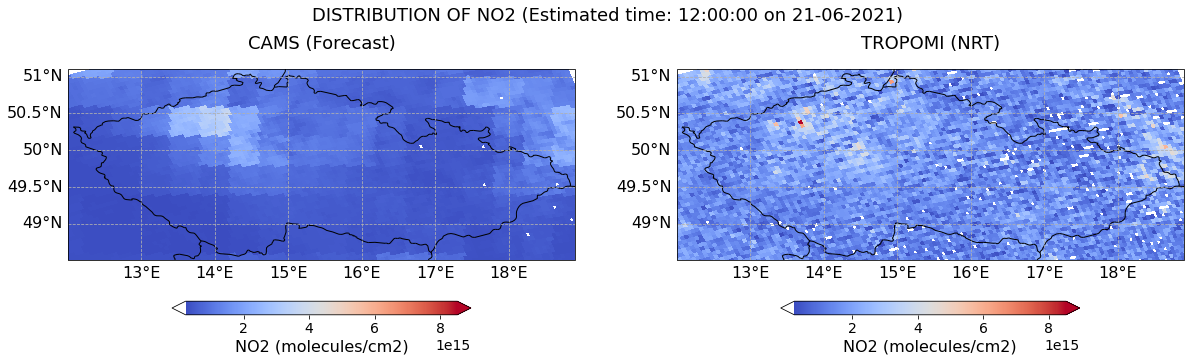

In [32]:
units = component_nom + ' (molecules/cm2)'
projection = ccrs.PlateCarree()

for t in range(TROPOMI.time.size):
    
    fig, axs = plt.subplots(1, 2, figsize = (20, 5), subplot_kw = {'projection': projection})
    
    # Define vmin
    if (np.nanmin(TROPOMI.isel(time = t)) < np.nanmin(CAMS.isel(time = t))) and np.nanmin(TROPOMI.isel(time = t)) >= 0:
        vmin = np.nanmin(TROPOMI.isel(time = t))
    else:
        vmin = np.nanmin(CAMS.isel(time = t))
    
    # Define vmax
    if np.nanmax(TROPOMI.isel(time = t)) < np.nanmax(CAMS.isel(time = t)):
        vmax = np.nanmax(CAMS.isel(time = t))
    else:
        vmax = np.nanmax(TROPOMI.isel(time = t))

    # First plot - CAMS
    array = CAMS.isel(time = t)
    long_name = 'CAMS (Forecast)'
    visualize_pcolormesh(
                        fig = fig, axs = axs[0],
                        data_array = array.fillna(-999),
                        longitude = array.longitude,
                        latitude = array.latitude,
                        projection = ccrs.PlateCarree(),
                        color_scale = 'coolwarm',
                        long_name = long_name,
                        units = units,
                        vmin = vmin, 
                        vmax = vmax, 
                        set_global = False,
                        lonmin = bbox[0][0],
                        lonmax = bbox[1][0],
                        latmin = bbox[0][1],
                        latmax = bbox[1][1]
                        )

    # Second plot - TROPOMI
    array = TROPOMI.isel(time = t)
    long_name = 'TROPOMI (NRT)'
    visualize_pcolormesh(
                        fig = fig, axs = axs[1],
                        data_array = array.fillna(-999),
                        longitude = array.longitude,
                        latitude = array.latitude,
                        projection = ccrs.PlateCarree(),
                        color_scale = 'coolwarm',
                        long_name = long_name,
                        units = units,
                        vmin = vmin,  
                        vmax = vmax, 
                        set_global = False,
                        lonmin = bbox[0][0],
                        lonmax = bbox[1][0],
                        latmin = bbox[0][1],
                        latmax = bbox[1][1]
                        )

    fig.suptitle(f'DISTRIBUTION OF {component_nom} (Estimated time: 12:00:00 on 21-06-2021)', 
                  fontsize = 18)
    plt.show()


## References
### Data sources
* CAMS global atmospheric composition forecasts (https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-atmospheric-composition-forecasts?tab=overview)
* TROPOMI (https://s5phub.copernicus.eu/dhus)

### Background
* TROPOMI user manual (https://sentinels.copernicus.eu/documents/247904/3119978/Sentinel-5P-Level-2-Input-Output-Data-Definition)

### External functions
* Interpolation (http://christopherbull.com.au/python/scipy-interpolate-griddata/)
* Visualization function (https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/blob/master/functions.ipynb)
* Mask NaN values (https://matplotlib.org/2.0.2/examples/pylab_examples/image_masked.html)
* Convert units (https://confluence.ecmwf.int/pages/viewpage.action?pageId=153391710)
* Install eccodes (https://gist.github.com/MHBalsmeier/a01ad4e07ecf467c90fad2ac7719844a)